# Business Requirements - ETL  

### 1. Functional Requirements - Load Credit Card Database (SQL)

Req-1.1 Data Extraction and Transformation with Python and PySpark

For “Credit Card System,” create a Python and PySpark SQL program to read/extract the following JSON files    
        according to the specifications found in the mapping document.

        1. CDW_SAPP_BRANCH.JSON
        2. CDW_SAPP_CREDITCARD.JSON
        3. CDW_SAPP_CUSTOMER.JSON       


In [98]:
#import required libreries
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from dotenv import load_dotenv
import os
import pandas as pd 
import matplotlib.pyplot as plt
import random
import requests
import numpy as np
import re
import mysql.connector as mariadb

In [4]:
#create spark session
spark = SparkSession.builder.master("local[*]").appName("Capstone").getOrCreate()

In [99]:
#load/read cdw_sapp_custmer.json file into spark dataframe 
customer_df=spark.read.load("creditcard_system_data/cdw_sapp_custmer.json",format="json")

In [100]:
#show first five records from the customer dataframe
customer_df.show(5,truncate=False)

+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+-----------------------------+-----------+---------+-----------------+
|APT_NO|CREDIT_CARD_NO  |CUST_CITY   |CUST_COUNTRY |CUST_EMAIL         |CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|LAST_UPDATED                 |MIDDLE_NAME|SSN      |STREET_NAME      |
+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+-----------------------------+-----------+---------+-----------------+
|656   |4210653310061055|Natchez     |United States|AHooper@example.com|1237818   |MS        |39120   |Alec      |Hooper   |2018-04-21T12:49:02.000-04:00|Wm         |123456100|Main Street North|
|829   |4210653310102868|Wethersfield|United States|EHolman@example.com|1238933   |CT        |06109   |Etta      |Holman   |2018-04-21T12:49:02.000-04:00|Brendan    |123453023|Redwood Drive    |
|683   |4210653310116272|

In [101]:
#print schema of the dataset
customer_df.printSchema()

root
 |-- APT_NO: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)



In [102]:
#temporary table view of the custmer dataframe
customer_df.createOrReplaceTempView("customer")

In [1310]:
#trnasform data as per mapping document
transform_customer_df=spark.sql("SELECT CAST(SSN AS INT) AS SSN,\
                            CONCAT(UPPER(SUBSTR(FIRST_NAME,1,1)),LOWER(substr(FIRST_NAME,2))) AS FIRST_NAME, \
                            CONCAT(LOWER(MIDDLE_NAME)) MIDDLE_NAME, \
                            CONCAT(UPPER(substr(LAST_NAME,1,1)),LOWER(substr(LAST_NAME,2))) AS LAST_NAME, \
                            CREDIT_CARD_NO,\
                            CONCAT(STREET_NAME, ',' ,APT_NO) AS FULL_STREET_ADDRESS, \
                            CUST_CITY, \
                            CUST_STATE, \
                            CUST_COUNTRY,\
                            CAST(CUST_ZIP AS INT) AS CUST_ZIP, \
                            CONCAT('(',LEFT(RAND()*100+201,3),')',SUBSTR(CUST_PHONE,1,3),'-',SUBSTR(CUST_PHONE,4)) AS CUST_PHONE, \
                            CUST_EMAIL,\
                            CAST(LAST_UPDATED AS TIMESTAMP) AS LAST_UPDATED\
                            FROM customer")


In [52]:
#show first 5 records from the transform customer dataframe
transform_customer_df.show(5,truncate=False)

+---------+----------+-----------+---------+----------------+---------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|SSN      |FIRST_NAME|MIDDLE_NAME|LAST_NAME|CREDIT_CARD_NO  |FULL_STREET_ADDRESS  |CUST_CITY   |CUST_STATE|CUST_COUNTRY |CUST_ZIP|CUST_PHONE   |CUST_EMAIL         |LAST_UPDATED       |
+---------+----------+-----------+---------+----------------+---------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|123456100|Alec      |wm         |Hooper   |4210653310061055|Main Street North,656|Natchez     |MS        |United States|39120   |(208)123-7818|AHooper@example.com|2018-04-21 12:49:02|
|123453023|Etta      |brendan    |Holman   |4210653310102868|Redwood Drive,829    |Wethersfield|CT        |United States|6109    |(243)123-8933|EHolman@example.com|2018-04-21 12:49:02|
|123454487|Wilber    |ezequiel   |Dunham   |4210653310116272|12th Street Ea

In [53]:
#printschema of transform cutomer dataframe
transform_customer_df.printSchema()

root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [103]:
#read/load cdw_sapp_branch.json file into spark branch dataframe
branch_df=spark.read.load("creditcard_system_data/cdw_sapp_branch.json",format="json")

In [104]:
#show first five record from branch dataframe
branch_df.show(4,truncate=False)

+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|BRANCH_CITY      |BRANCH_CODE|BRANCH_NAME |BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET    |BRANCH_ZIP|LAST_UPDATED                 |
+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|Lakeville        |1          |Example Bank|1234565276  |MN          |Bridle Court     |55044     |2018-04-18T16:51:47.000-04:00|
|Huntley          |2          |Example Bank|1234618993  |IL          |Washington Street|60142     |2018-04-18T16:51:47.000-04:00|
|SouthRichmondHill|3          |Example Bank|1234985926  |NY          |Warren Street    |11419     |2018-04-18T16:51:47.000-04:00|
|Middleburg       |4          |Example Bank|1234663064  |FL          |Cleveland Street |32068     |2018-04-18T16:51:47.000-04:00|
+-----------------+-----------+------------+------------+------------+-----------------+--

In [105]:
#print schema of brach dataframe
branch_df.printSchema()

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)



In [106]:
#transformed branch dataframe according to the mapping document
transform_branch_df=branch_df.select(col("BRANCH_CODE").astype('int').alias('BRANCH_CODE'),\
                 col("BRANCH_NAME"),\
                 col("BRANCH_STREET"), \
                 col("BRANCH_CITY"),\
                 col("BRANCH_STATE"), \
                 when(col("BRANCH_ZIP").isNull(),'99999').otherwise(col("BRANCH_ZIP")).astype('int').alias('BRANCH_ZIP'),\
                 (concat( lit("(") ,substring(col("BRANCH_PHONE"),1,3),lit(")") ,substring(col("BRANCH_PHONE"),4,3), \
                          lit("-") ,substring(col("BRANCH_PHONE"),7,4) )).alias("BRANCH_PHONE"),\
                 to_timestamp(col("LAST_UPDATED")).alias("LAST_UPDATED")
                )

In [1315]:
#print schema of transformed branch dataframe
transform_branch_df.printSchema()

root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_ZIP: integer (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [1316]:
#show first five records from transformed dataframe
transform_branch_df.show(5,truncate=True)

+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|       LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18 16:51:47|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18 16:51:47|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18 16:51:47|
|          4|Example Bank| Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|2018-04-18 16:51:47|
|          5|Example Bank|      14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|2018-04-18 16:51:47|
+-----------+------------+------

In [107]:
#read/load cdw_sapp_credit.json file into pandas credit dataframe
credit_df=spark.read.load("creditcard_system_data/cdw_sapp_credit.json",format="json").toPandas()

In [77]:
#first five records from credit dataframe
credit_df.head(5)

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR
0,114,4210653349028689,123459988,14,2,1,Education,78.90,2018
1,35,4210653349028689,123459988,20,3,2,Entertainment,14.24,2018
2,160,4210653349028689,123459988,8,7,3,Grocery,56.70,2018
3,114,4210653349028689,123459988,19,4,4,Entertainment,59.73,2018
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018


In [78]:
#datatypes of credit dataset
credit_df.dtypes

BRANCH_CODE            int64
CREDIT_CARD_NO        object
CUST_SSN               int64
DAY                    int64
MONTH                  int64
TRANSACTION_ID         int64
TRANSACTION_TYPE      object
TRANSACTION_VALUE    float64
YEAR                   int64
dtype: object

In [79]:
#transform credit dataframe according to mapping document
credit_df['MONTH']=credit_df['MONTH'].astype(str).str.zfill(2)
credit_df['DAY']=credit_df['DAY'].astype(str).str.zfill(2)
credit_df["TIMEID"]=credit_df['YEAR'].astype(str)+ \
                    credit_df['MONTH'] + credit_df['DAY']
credit_df.rename(columns={'CREDIT_CARD_NO':'CUST_CC_NO'},inplace=True)

In [80]:
#first 10 records from the transformed dataframe
credit_df.head(10)

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR,TIMEID
0,114,4210653349028689,123459988,14,02,1,Education,78.90,2018,20180214
1,35,4210653349028689,123459988,20,03,2,Entertainment,14.24,2018,20180320
2,160,4210653349028689,123459988,08,07,3,Grocery,56.70,2018,20180708
3,114,4210653349028689,123459988,19,04,4,Entertainment,59.73,2018,20180419
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018,20181010
5,164,4210653349028689,123459988,28,05,6,Education,6.89,2018,20180528
6,119,4210653349028689,123459988,19,05,7,Entertainment,43.39,2018,20180519
7,23,4210653349028689,123459988,08,08,8,Gas,95.39,2018,20180808
8,166,4210653349028689,123459988,18,03,9,Entertainment,93.26,2018,20180318
9,83,4210653349028689,123459988,03,09,10,Bills,100.38,2018,20180903


In [81]:
#selected columns to be added into transformed dataframe
trans_credit_df=credit_df[['CUST_CC_NO','TIMEID','CUST_SSN','BRANCH_CODE','TRANSACTION_TYPE','TRANSACTION_VALUE','TRANSACTION_ID']]

In [82]:
#first 10 records from transformed customer dataframe
trans_credit_df.head(10)

,CUST_CC_NO,TIMEID,CUST_SSN,BRANCH_CODE,TRANSACTION_TYPE,TRANSACTION_VALUE,TRANSACTION_ID
0,4210653349028689,20180214,123459988,114,Education,78.90,1
1,4210653349028689,20180320,123459988,35,Entertainment,14.24,2
2,4210653349028689,20180708,123459988,160,Grocery,56.70,3
3,4210653349028689,20180419,123459988,114,Entertainment,59.73,4
4,4210653349028689,20181010,123459988,93,Gas,3.59,5
5,4210653349028689,20180528,123459988,164,Education,6.89,6
6,4210653349028689,20180519,123459988,119,Entertainment,43.39,7
7,4210653349028689,20180808,123459988,23,Gas,95.39,8
8,4210653349028689,20180318,123459988,166,Entertainment,93.26,9
9,4210653349028689,20180903,123459988,83,Bills,100.38,10


In [84]:
#creting spark dataframe from transformed pandas customer dataframe
transform_credit_df=spark.createDataFrame(trans_credit_df)

In [85]:
#show first five records from customer spark dataframe
transform_credit_df.show(5,truncate=True)

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
only showing top 5 rows



In [108]:
load_dotenv()
USER=os.environ.get('user')
PASSWORD=os.environ.get('password')

### Req-1.2   
Data loading into Database


Create a Python and Pyspark Program to load/write the “Credit Card System Data” into RDBMS(creditcard_capstone).     
Tables should be created by the following names in RDBMS:     

      CDW_SAPP_BRANCH    
      CDW_SAPP_CREDIT_CARD    
      CDW_SAPP_CUSTOMER   


In [1100]:
def tables_exist(database,tablename):
    db_table_schema=spark.read\
                        .format("jdbc")\
                        .option("url", "jdbc:mysql://localhost:3308/") \
                        .option("user", USER) \
                        .option("password", PASSWORD) \
                        .option("dbtable","information_schema.tables")\
                        .load()\
                        .filter("table_schema='{}'".format(database))
    res=db_table_schema.select('TABLE_NAME')
    return tablename in res.toPandas().values      
   

In [87]:
#load branch data from spark dataframe into reditcard_capstone.CDW_SAPP_BRANCH table in RDBMS
transform_branch_df.write \
                    .format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate","true") \
                    .option("url", "jdbc:mysql://localhost:3308/") \
                    .option("createTableColumnTypes", "BRANCH_CODE INT,BRANCH_NAME VARCHAR(25),BRANCH_STREET VARCHAR(50),\
                                                       BRANCH_CITY VARCHAR(25), BRANCH_STATE VARCHAR(10),BRANCH_ZIP INT,\
                                                       BRANCH_PHONE VARCHAR(25),LAST_UPDATED TIMESTAMP")\
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
                    .option("truncate","true") \
                    .option("user", USER) \
                    .option("password", PASSWORD) \
                    .option("characterEncoding","UTF-8") \
                    .option("useUnicode", "true") \
                    .save()

In [89]:
#load creditcard data from spark dataframe into reditcard_capstone.CDW_SAPP_CREDIT_CARD table in RDBMS
transform_credit_df.write \
                    .format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate","true") \
                    .option("url", "jdbc:mysql://localhost:3308/") \
                    .option("createTableColumnTypes", "CUST_CC_NO VARCHAR(25),TIMEID VARCHAR(15),CUST_SSN INT,\
                                                       BRANCH_CODE INT, TRANSACTION_TYPE VARCHAR(25),TRANSACTION_VALUE DOUBLE,\
                                                       TRANSACTION_ID INT")\
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
                    .option("truncate","true") \
                    .option("user", USER) \
                    .option("password", PASSWORD) \
                    .option("characterEncoding","UTF-8") \
                    .option("useUnicode", "true") \
                    .save()

In [92]:
#load cUSTOMER data from spark dataframe into reditcard_capstone.CDW_SAPP_CREDIT_CARD table in RDBMS
transform_customer_df.write \
                    .format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate","true") \
                    .option("url", "jdbc:mysql://localhost:3308/") \
                    .option("createTableColumnTypes", "SSN INT,FIRST_NAME VARCHAR(25),MIDDLE_NAME VARCHAR(25),LAST_NAME VARCHAR(25),\
                                                       CREDIT_CARD_NO VARCHAR(25),FULL_STREET_ADDRESS VARCHAR(50),CUST_CITY VARCHAR(25),\
                                                       CUST_STATE VARCHAR(25),CUST_COUNTRY VARCHAR(25),CUST_ZIP INT,CUST_PHONE VARCHAR(15),\
                                                       CUST_EMAIL VARCHAR(50),LAST_UPDATED TIMESTAMP")\
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
                    .option("truncate","true") \
                    .option("user", USER) \
                    .option("password", PASSWORD) \
                    .option("characterEncoding","UTF-8") \
                    .option("useUnicode", "true") \
                    .save()

### 2. Functional Requirements - Application Front-End

Once data is loaded into the database, we need a front-end (console) to see/display data.    
For that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2).   

 2.1 Transaction Details Module \    
* 1. Used to display the transactions made by customers living in a given zip code for a given month and year. 
              Order by day in descending order.
* 2.  Used to display the number and total values of transactions for a given type.          
* 3.  Used to display the number and total values of transactions for branches in a given state.    

2.2 Customer Details Module     
* 1. Used to check the existing account details of a customer.   
* 2. Used to modify the existing account details of a customer.  
* 3. Used to generate a monthly bill for a credit card number for a given month and year.    
* 4. Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.   

In [109]:
#function to load data from database to spark dataframe
def load_data(USER,PASSWORD):
      """function loads returns data from RDBMS to spark dataframe"""
#load branch data from creditcard_capstone.CDW_SAPP_BRANCH to spark dataframe
      load_branch=spark.read\
                        .format("jdbc")\
                        .options(driver="com.mysql.cj.jdbc.Driver",\
                                    user=USER,\
                                    password=PASSWORD,\
                                    url="jdbc:mysql://localhost:3308/",\
                                    dbtable="creditcard_capstone.CDW_SAPP_BRANCH")\
                        .load()

#load creditcard data from creditcard_capstone.CDW_SAPP_CREDIT_CARD to spark dataframe
      load_credit=spark.read\
                        .format("jdbc")\
                        .options(driver="com.mysql.cj.jdbc.Driver",\
                                    user=USER,\
                                    password=PASSWORD,\
                                    url="jdbc:mysql://localhost:3308/",\
                                    dbtable="creditcard_capstone.CDW_SAPP_CREDIT_CARD")\
                        .load()

#load customer data from creditcard_capstone.CDW_SAPP_CUSTOMER to spark dataframe
      load_customer=spark.read\
                        .format("jdbc")\
                        .options(driver="com.mysql.cj.jdbc.Driver",\
                                    user=USER,\
                                    password=PASSWORD,\
                                    url="jdbc:mysql://localhost:3308/",\
                                    dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER")\
                        .load()
      return load_branch,load_credit,load_customer


In [110]:
load_branch,load_credit,load_customer=load_data(USER,PASSWORD)
#create temp vew of spark dataframe
load_branch.createOrReplaceTempView('branch')
load_credit.createOrReplaceTempView("credit_card")
load_customer.createOrReplaceTempView("customer")

 #### 2.1 Transaction Details Module

 * 1. Used to display the transactions made by customers living in a given zip code for a given month and year. 
              Order by day in descending order.
* 2.  Used to display the number and total values of transactions for a given type.          
* 3.  Used to display the number and total values of transactions for branches in a given state.

In [3]:
#decorator to change funcionality of the print function
def Dprint(f):
    def inner(*arg,**kwarg):
        r=f(*arg,**kwarg)
        r.show()
        # return r
    return inner

* 1. Used to display the transactions made by customers living in a given zip code for a given month and year.     
              Order by day in descending order.

In [111]:
# @Dprint
def transaction_by_zipcode(zipcode,year,month):
        data= spark.sql("SELECT c.CUST_ZIP, \
                      c.FIRST_NAME, \
                      c.LAST_NAME,\
                      c.LAST_UPDATED,\
                      cc.*\
                      FROM credit_card cc\
                      JOIN customer c ON  c.SSN=cc.CUST_SSN\
                      WHERE c.CUST_ZIP = '{}' AND YEAR(to_date(TIMEID,'yyyyMMdd')) = '{}' \
                      AND MONTH(to_date(TIMEID,'yyyyMMdd'))='{}'\
                      ORDER BY day(to_date(TIMEID,'yyyyMMdd')) DESC".format(zipcode,year,month))
        return data

In [5]:
def input_zipcode():
    while True:
        zipcode=input("\n Enter zipcode using 4-5 digits : ")
        zipcode=zipcode.strip()
        if (zipcode.isdigit()) and (len(zipcode) > 3 or len(zipcode) < 6):
            print("\n Valid zipcode")
            break
        else:
            print("\n Invalid zipcode entry...Try again")
    return zipcode

In [6]:
 #year input  
def input_year():     
    while True:
        year=input("\n Enter year using 4 digits :")
        year=year.strip()
        if year.isdigit() and len(year)==4:
            print("\n Valid Year")
            break
        else:
            print("\n Invalid year entry...Try again :")
    return year

In [7]:
#month input
def input_month():
    while True:
        month=input("\n Enter month using 2 digits (example: March enter 03): ")
        month=month.strip().lstrip('0')
        if month.isdigit():
            if int(month) in range (1,13):
                print("\n Valid month :")
                break
            else:
                print("\n Invalid month entry...Try again :")
        else:
            print("\n Invalid month entry...Try again :")
    return month

In [17]:
#function to get zipcode, year, month user input 
def tran1_input():
    #zipcode input
    zipcode=input_zipcode()
    #year input       
    year=input_year()
    #month input
    month=input_month()
    return zipcode,year,month  

In [33]:
#calling function tran1_input() to get user input for zipcode, year and month.
#the return value of function is valid user input zipcode,year,month
zipcode,year,month=tran1_input()
print("\n Transactions made by customers living in zip code :{}, for a year :{}, and month :{} \n\
 output Order by day in descending order".format(zipcode,year,month))   
tras_zip=transaction_by_zipcode(zipcode,year,month)
tras_zip=tras_zip.withColumn('CUST_SSN',concat(lit('XXXXX'),substring(col('CUST_SSN'),6,4)))
tras_zip=tras_zip.withColumn('CUST_CC_NO',concat(lit('XXXXXXXXXXXX'),substring(col('CUST_CC_NO'),8,12))).show()
# transaction_by_zipcode(60142,2018,9)


 Valid zipcode

 Valid Year

 Valid month :

 Transactions made by customers living in zip code :60142, for a year :2018, and month :9 
 output Order by day in descending order
+--------+----------+---------+-------------------+--------------------+--------+---------+-----------+----------------+-----------------+--------------+
|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|          CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+--------+----------+---------+-------------------+--------------------+--------+---------+-----------+----------------+-----------------+--------------+
|   60142|    Rodger|   Chacon|2018-04-21 12:49:02|XXXXXXXXXXXX31647...|20180928|XXXXX7245|         31|       Education|            37.61|         14278|
|   60142|    Rodger|   Chacon|2018-04-21 12:49:02|XXXXXXXXXXXX31647...|20180927|XXXXX7245|          8|            Test|            12.84|         14293|
|   60142|  Cristina|  Spencer|2018-04-21 12:49:02|X

: 

* 2)    Used to display the number and total values of transactions for a given type.

In [414]:
 #function to get the number and total values of transactions for a given type.
@Dprint
def tran_no_total_by(tr_type):
    return spark.sql("SELECT TRANSACTION_TYPE, COUNT(TRANSACTION_ID) AS NUM_OF_TRANSACTION, \
                        SUM(TRANSACTION_VALUE) AS TOTAL_TRAN_VALUES FROM credit_card\
                        WHERE TRANSACTION_TYPE='{}'\
                        GROUP BY TRANSACTION_TYPE".format(tr_type))   

In [411]:
#funtion to get user input for transaction type
def tran2_input():
    print("Available Transaction Type")
    transaction_type=spark.sql("SELECT DISTINCT(TRANSACTION_TYPE) FROM credit_card")
    transaction_type.show()
    transaction_type= transaction_type.toPandas()
    transaction_type_list=pd.unique(transaction_type['TRANSACTION_TYPE'])
    while True:        
        tr_type=input("\nEnter Transaction Type : ")
        tr_type=tr_type.strip()
        if tr_type.title() in transaction_type_list:
            print("Valid Transaction Type ")
            break
        else:
            print("\nEntered Transaction type not found.. Try again..")
    return tr_type

In [415]:
tr_type=tran2_input()
tran_no_total_by(tr_type)

Available Transaction Type
+----------------+
|TRANSACTION_TYPE|
+----------------+
|       Education|
|   Entertainment|
|      Healthcare|
|         Grocery|
|            Test|
|             Gas|
|           Bills|
+----------------+

Valid Transaction Type
+----------------+------------------+------------------+
|TRANSACTION_TYPE|NUM_OF_TRANSACTION| TOTAL_TRAN_VALUES|
+----------------+------------------+------------------+
|             Gas|              6605|336059.25999999954|
+----------------+------------------+------------------+



* 3)    Used to display the number and total values of transactions for branches in a given state.

In [486]:
# function display the number and total values of transactions for branches in a given state.
@Dprint
def tran_no_total_byst(state):
    return spark.sql("SELECT cc.BRANCH_CODE AS BRANCH_CODE, \
                            COUNT(cc.TRANSACTION_ID) AS NO_TRANSACTION, \
                            SUM(TRANSACTION_VALUE) AS TOTAL_VALUE \
                            FROM customer C \
                            LEFT JOIN credit_card cc on C.SSN = cc.CUST_SSN \
                            WHERE C.CUST_STATE = '{}'\
                            GROUP BY cc.BRANCH_CODE\
                            ORDER BY cc.BRANCH_CODE".format(state))

In [519]:
#function to get user input for state.
def tran3_input():
    tr_state=spark.sql("SELECT DISTINCT(BRANCH_STATE) AS STATES FROM branch")
    tr_state= tr_state.toPandas()
    tr_state_list=pd.unique(tr_state['STATES'])
    print("Available Transaction States ::\n {}".format(tr_state_list))
    while True:
        state=input("\n Enter State using 2 letters as shown in above list")
        state=state.strip()
        if state.isalpha() and len(state) == 2:
            if state.upper() in tr_state_list:
                print("\nEntry is available for the entered state '{}' ::".format(state.upper()))
                break
            else:
                print("\nState is not found in list..Try again..")
        else:
            print("\nInvalid entry...Try again")
    return state


In [520]:
#calling using input. return type of this function is valid available state
state=tran3_input()
#calling function to get the number and total values of transactions for branches in a given state.
print("\n")
tran_no_total_byst(state)

Available Transaction States ::
 ['SC' 'MN' 'NJ' 'VA' 'KY' 'MI' 'WI' 'CA' 'CT' 'MT' 'NC' 'MD' 'IL' 'WA'
 'MS' 'AL' 'IN' 'OH' 'IA' 'PA' 'NY' 'TX' 'GA' 'MA' 'FL' 'AR']

Entry is available for the entered state 'NY' ::


+-----------+--------------+------------------+
|BRANCH_CODE|NO_TRANSACTION|       TOTAL_VALUE|
+-----------+--------------+------------------+
|          1|            30|1582.3599999999994|
|          2|            33|1536.2899999999997|
|          3|            54|2726.0399999999995|
|          4|            44|2031.4200000000003|
|          5|            34|1646.3100000000002|
|          7|            39|2092.0299999999997|
|          8|            43|           2193.71|
|          9|            45|2452.4100000000008|
|         10|            37|2112.6799999999994|
|         11|            46|2365.2100000000005|
|         12|            45|           2263.95|
|         14|            45|           2604.02|
|         15|            37|1918.7100000000003|
|         16| 

 #### 2.2 Customer Details Module

* 1. Used to check the existing account details of a customer.   
* 2. Used to modify the existing account details of a customer.  
* 3. Used to generate a monthly bill for a credit card number for a given month and year.    
* 4. Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


* 1. Used to check the existing account details of a customer. 

In [618]:
#function to check the existing account details of a customer by ssn, first name and last name
@Dprint
def cust_details_byssn(ssn,name,lastname):
    return spark.sql("SELECT * FROM CUSTOMER \
               WHERE SSN = '{}' AND FIRST_NAME='{}' AND LAST_NAME='{}'" \
                    .format(ssn,name,lastname))

In [598]:
#function to check the existing account details of a customer by credit card number, full name, phone number and registermail.
@Dprint
def cust_details_bycc(name,middlename,lastname,email,cc_number,phone):
    return spark.sql("SELECT * FROM CUSTOMER \
               WHERE FIRST_NAME='{}' AND MIDDLE_NAME='{}' AND LAST_NAME='{}' \
                     AND CUST_EMAIL ='{}' AND CREDIT_CARD_NO = '{}'\
                     AND CUST_PHONE = '{}' "\
                    .format(name,middlename,lastname,email,cc_number,phone))

In [751]:
#ssn input
def input_ssn():
     while True:
          print("SSN Details")
          ssn = input("Enter ssn for customer using 9 digits :")
          ssn=ssn.replace('-','').replace(' ','')
          if ssn.isdigit() and len(ssn) == 9:
               print("Valid SSN ")
               break
          else:
               print("Invalid ssn.. Try again :")
     return ssn

In [752]:
#function to get credit card number user input
def input_cc():
    while True:
        print("Enter 16 digit credit card number :")
        cc_number=input("Enter 16 digit credit card number ::")
        if cc_number.isdigit() and len(cc_number) == 16:
            print("Valid input :")
            print(cc_number)
            break
        else:
            print("invalid input  ..Try again")
    return cc_number

In [1426]:
# phone number input
def input_phone_no():
     while True:
          print("Input valid 10 digit phone number ::")
          phone=input("Input 10 digit phone number")
          if phone.isdigit() and len(phone) == 10:
               print("Valid Input : ")
               print(phone)
               break
          else:
               print("Invalid phone number..TryAgin")
     phone=re.sub(r'(\d{3})(\d{3})(\d{4})',r'(\1)\2-\3',phone)
     # phone="("+phone[0:3]+')'+phone[3:6]+'-'+phone[6:10]
     return phone

In [754]:
#function get customer account details using ssn or credit card number
def cust1_details():
     while True:
          print("\nchoose option to check account details details of cust by ::")
          print("\n 1> Using SSN details :: ")
          print("\n 2> Using Credit card ")
          choice=input("Enter your Choice :")
          if choice.isdigit() and int(choice) in range(1,3):
               print("\nchoice :{}".format(choice))
               break
          else:
               print("Invalid choice..Tryagain")          
    
     if choice == '1':
          print("Customer Account Details by Using SSN")
          ssn=input_ssn()
          print(ssn)
          print("\nEnter name")
          name = input("Enter name ")
          name=name.strip()
          print(name)
          if name.isalpha():
               name=name.title()
          print("\nEnter Last name :")
          last_name=input("Enter last name")
          last_name=last_name.strip()
          print(last_name)
          if name.isalpha():
               last_name=last_name.title()
          cust_details_byssn(ssn,name,last_name)
     else:
          print("Customer account details by using Creditcard ::")
          cc_number=input_cc()
          print("\nEnter name ::")
          name = input("Enter First name ::")
          name=name.strip()
          print(name)
          if name.isalpha():
               name=name.title()
          print("\nEnter middle name ::")
          middle_name=input("Enter Middle name")
          middle_name=middle_name.strip()
          print(middle_name)
          if middle_name.isalpha():
               middle_name=middle_name.lower()
          print("\nEnter Last name ::")
          last_name=input("Enter last name")
          last_name=last_name.strip()
          print(last_name)
          if last_name.isalpha():
               last_name=last_name.title()
          print("Enter Email address ::")
          email=input("Enter registered email id ")
          email=email.strip()
          print(email)
          phone=input_phone_no()                              
          cust_details_bycc(name,middle_name,last_name,email,cc_number,phone)

In [755]:
#lets get customer details using ssn
cust1_details()


choose option to check account details details of cust by ::

 1> Using SSN details :: 

 2> Using Credit card 

choice :1
Customer Account Details by Using SSN
SSN Details
Valid SSN 
123451995

Enter name
Lorna

Enter Last name :
Diaz
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-----------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|       CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-----------------+-------------------+
|123451995|     Lorna|      aimee|     Diaz|4210653314812374|Lafayette Street,847|    Osseo|        MN|United States|   55311|(281)124-1214|LDiaz@example.com|2018-04-21 12:49:02|
+---------+----------+-----------+---------+---

In [756]:
cust1_details()


choose option to check account details details of cust by ::

 1> Using SSN details :: 

 2> Using Credit card 

choice :2
Customer account details by using Creditcard ::
Enter 16 digit credit card number :
Valid input :
4210653314812374

Enter name ::
Lorna

Enter middle name ::
aimee

Enter Last name ::
Diaz
Enter Email address ::
LDiaz@example.com
Input valid 10 digit phone number ::
Valid Input : 
2811241214
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-----------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|       CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-----------------+-------------------+
|123451995|     Lorna|      aimee|     Diaz|42

* 2) Used to modify the existing account details of a customer.

In [62]:
import mysql.connector as mariadb
con = mariadb.connect(host = "127.0.0.1", 
        port = 3308,
        user = "root",
        password="password",
        database="capstone"
    )

In [63]:
def input_name(tp):
      while True:
            name = input("Enter {} Name :: ".format(tp))
            name=name.strip()
            pattern=re.compile(r"^(\w+)$")
            if pattern.match(name):
               name=name.title()
               break
            else:
                  print("Invalid Input...Try again..")
      return name

In [66]:
#ssn input
def input_ssn():
     while True:
          print("SSN Details")
          ssn = input("Enter ssn for customer using 9 digits:: ")
          ssn=ssn.replace('-','').replace(' ','')
          if ssn.isdigit() and len(ssn) == 9:
              break
          else:
               print("Invalid ssn.. Try again ..")
     return ssn

In [67]:
def modify_fields():
     while True:
          print("\n Select which fields you want to modify from follwing options::")
          print("\n1. Address")
          print("\n2. Email Address")
          print("\n3. Both")
          choice=input("\nEnter Selection :: ")
          choice=choice.strip()
          if choice.isdigit() and int(choice) in range(1,3):
               print("\nchoice :{}".format(choice))
               break
          else:
               print("Invalid choice..Tryagain")
     return choice

In [89]:
def input_zipcode():
    while True:
        zipcode=input("\nEnter zipcode using 4-5 digits :: ")
        zipcode=zipcode.strip()
        regex = re.compile(r'^(\d{4,5})$')
        if re.fullmatch(regex, zipcode):
            break
        else:
            print("\n Invalid zipcode entry...Try again..")
    return zipcode

In [90]:
def input_address():
    print("Enter appartment Number")
    address={}
    while True:
        apt_no=input("Appartment No")
        apt_no=apt_no.strip()
        if apt_no.isdigit() and int(apt_no) > 0:
            address['APT_NO']=apt_no
            break
        else:
            ("Invalid entry.. Try again")
    while True:
        street_name=input("Input street name : ")
        pattern=re.compile(r"^(\w+)\s?(\w+\s*)*$")
        if pattern.match(street_name):
            st=street_name.split(" ")
            if st[0][0].isdigit():
                street_name=st[0]+ " "+" ".join(st[1:]).title()
            else:
                street_name=street_name.title()
            address['STREET_NAME']=street_name
            break
        else:
            print("Invalid ")
    while True:
        city_name=input("Input City Name without any space : ")
        city_name=city_name.strip()
        pattern=re.compile(r"^(\w+)$")
        if pattern.match(city_name):
             address['CITY_NAME']=city_name.title()
             break
        else:
            print("invalid")

    while True:
        state=input("State (Abbreviation) e.x.(Alaska as 'AK'")
        state=state.upper().strip()
        st_list=['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI'\
              ,'MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT'\
                ,'VT','VA','WA','WV','WI','WY']
        if state.isalpha() and len(state)==2 and state in st_list:
            address['CUST_STATE']=state
            break
        else:
            print("invalid input")

    address['CUST_ZIP']=int(input_zipcode())
    address['FULL_STREET_ADDRESS']=address['STREET_NAME']+','+str(address['APT_NO'])     
            
    return address

In [91]:
def input_email():
    print("Enter valid email address :")
    while True:
        email=input("Enter Email Address :: ")
        regex = re.compile(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+')
        if re.fullmatch(regex, email):
            print("Valid email")
            break
        else:
            print("invalid")
    return email

In [92]:
def execute_update_query(db_cursor,query,query1):
    try:
        db_cursor.execute(query)
        con.commit()
        print("Record updated successfully")
        db_cursor.execute(query1)
        cr=db_cursor.fetchall()
        print(cr)
    except Exception as e:
        print(e)


In [93]:
def modify_cust_details():
    try:        
        con = mariadb.connect(host = "127.0.0.1", 
        port = 3308,
        user = "root",
        password="password",
        database="capstone")
    except Exception as e:
        print(e)
    print("Connected to bd")
    db_cursor=con.cursor()
    print("Please enter the SSN no of the user you wish to modify :: ")
    ssn=input_ssn()
    name=input_name("First")
    last_name=input_name("Last")
    # query_alter="ALTER TABLE cdw_sapp_customer MODIFY COLUMN LAST_UPDATED TIMESTAMP DEFAULT CURRENT_TIMESTAMP \
    #              ON UPDATE CURRENT_TIMESTAMP"
    # db_cursor.execute(query_alter)
    query1="SELECT FIRST_NAME,MIDDLE_NAME,LAST_NAME,CREDIT_CARD_NO,FULL_STREET_ADDRESS,CUST_CITY,\
                           CUST_STATE, CUST_COUNTRY,CUST_ZIP,CUST_PHONE,CUST_EMAIL,LAST_UPDATED \
                           FROM cdw_sapp_customer WHERE SSN = '{}' and FIRST_NAME ='{}' and LAST_NAME='{}'".format(ssn,name,last_name)
    db_cursor.execute(query1)
    cr=db_cursor.fetchall()
    print(cr)
    if len(cr) == 0:
        print("One or more inputs were invalid or record does not exist in the database for given ssn  ")
    else:
        choice=int(modify_fields())
        match choice:
            case 1:
                address=input_address()
                print(address)
                update_address="UPDATE cdw_sapp_customer SET FULL_STREET_ADDRESS='{}', CUST_CITY='{}', \
                                CUST_STATE='{}', CUST_ZIP='{}' , LAST_UPDATED=now() WHERE SSN = '{}' AND FIRST_NAME= '{}' AND LAST_NAME='{}'"\
                            .format(address['FULL_STREET_ADDRESS'],address['CITY_NAME'],address['CUST_STATE'],address['CUST_ZIP']\
                                  ,ssn,name,last_name)
                execute_update_query(db_cursor,update_address,query1)
            case 2:
                print("case2")
                email=input_email()
                update_email="UPDATE cdw_sapp_customer SET CUST_EMAIL='{}', LAST_UPDATED=now() \
                              WHERE SSN = '{}' AND FIRST_NAME= '{}' AND LAST_NAME= '{}'"\
                            .format(email,ssn,name,last_name)
                print(email)
                execute_update_query(db_cursor,update_email,query1)
            case 3:
                address=input_address()
                email=input_email()
                update_both="UPDATE cdw_sapp_customer SET FULL_STREET_ADDRESS='{}', CUST_CITY='{}', \
                            CUST_STATE='{}', CUST_ZIP='{}' , CUST_EMAIL='{}', LAST_UPDATED=now() WHERE SSN = '{}' \
                            AND FIRST_NAME= '{}' AND LAST_NAME='{}'"\
                            .format(address['FULL_STREET_ADDRESS'],address['CITY_NAME'],address['CUST_STATE'],\
                                    address['CUST_ZIP'],email,ssn,name,last_name)
                execute_update_query(db_cursor,update_both,query1)
                
    db_cursor.close()
    con.close()

In [79]:
modify_cust_details()

Connected to bd
Please enter the SSN no of the user you wish to modify :: 
SSN Details
valid
valid
[('Elsa', 'isabelle', 'Truong', '4210653310844617', '7th Main Street,34', 'Freemont', 'NJ', 'United States', 95140, '(294)123-6228', 'ETruong@example.com', datetime.datetime(2023, 2, 25, 21, 41, 46))]

 Select which fields you want to modify from follwing options::

1. Address

2. Email Address

3. Both

choice :1
Enter appartment Number
Valid zipcode
{'APT_NO': '34', 'STREET_NAME': '4th Street Main', 'CITY_NAME': 'Freemont', 'CUST_STATE': 'CA', 'CUST_ZIP': 95140, 'FULL_STREET_ADDRESS': '4th Street Main,34'}
Record updated successfully
[('Elsa', 'isabelle', 'Truong', '4210653310844617', '4th Street Main,34', 'Freemont', 'CA', 'United States', 95140, '(294)123-6228', 'ETruong@example.com', datetime.datetime(2023, 2, 25, 21, 52, 14))]


* 3) Used to generate a monthly bill for a credit card number for a given month and year.

In [682]:
#function to get custmer credit transaction details using credit card number
@Dprint
def get_cc(cc_number):
    return spark.sql("SELECT * FROM credit_card \
              WHERE CUST_CC_NO = '{}'".format(cc_number))


In [683]:
#function to get credit card yearly transaction details 
@Dprint 
def get_cc_yr(cc_number,year):
    return spark.sql("SELECT * FROM credit_card \
              WHERE CUST_CC_NO = '{}' AND YEAR(to_date(TIMEID,'yyyyMMdd')) = '{}' \
              ORDER BY MONTH(to_date(TIMEID,'yyyyMMdd')) DESC".format(cc_number,year))

In [695]:
#function to get credit card monthly transaction details 
@Dprint
def get_cc_mon(cc_number,year,mon):
    return spark.sql("SELECT * FROM credit_card \
              WHERE CUST_CC_NO = '{}' AND YEAR(to_date(TIMEID,'yyyyMMdd')) = '{}'\
              AND MONTH(to_date(TIMEID,'yyyyMMdd')) = '{}'"\
              .format(cc_number,year,mon))

In [702]:
#function to diplay monthly expenses
@Dprint
def monthly_exp(cc_number,month,yr):
    return spark.sql("SELECT SUM(TRANSACTION_VALUE) AS MONTHLY_BILL,cc.TRANSACTION_TYPE FROM credit_card cc\
           JOIN customer c ON cc.CUST_CC_NO=c.CREDIT_CARD_NO \
           WHERE cc.CUST_CC_NO = '{}' AND MONTH(to_date(TIMEID,'yyyyMMdd')) = '{}' \
           AND YEAR(to_date(TIMEID,'yyyyMMdd'))='{}'\
           GROUP BY cc.TRANSACTION_TYPE".format(cc_number,month,yr))

In [758]:
@Dprint
#function used to generate a monthly bill for a credit card number for a given month and year.
def monthly_bill(cc_number,month,yr):
    return spark.sql("SELECT SUM(TRANSACTION_VALUE) AS MONTHLY_TOTAL FROM credit_card cc\
                    JOIN customer c ON cc.CUST_CC_NO=c.CREDIT_CARD_NO \
                    WHERE cc.CUST_CC_NO = '{}' AND MONTH(to_date(TIMEID,'yyyyMMdd')) = '{}' \
                    AND YEAR(to_date(TIMEID,'yyyyMMdd'))='{}'\
                    GROUP BY cc.CUST_CC_NO".format(cc_number,month,yr))

In [759]:
#generate monthly bill
print("Enter credit card number ::")
cc_number=input_cc()
print(cc_number)
# get_cc(cc_number)
print("Enter year ::")
print(year)
year=input_year()
# get_cc_yr(cc_number,year)
month=input_month()
print(month)
get_cc_mon(cc_number,year,month)
print("Monthly expense")
monthly_exp(cc_number,month,year)
print("Monthly bill ::")
monthly_bill(cc_number,month,year)


Enter credit card number ::
Enter 16 digit credit card number :
Valid input :
4210653310116272
4210653310116272
Enter year ::
2018

 Valid Year

 Valid month :
1
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653310116272|20180107|123454487|         32|         Grocery|            43.49|         28701|
|4210653310116272|20180114|123454487|         60|         Grocery|            73.09|         28712|
|4210653310116272|20180101|123454487|         69|           Bills|            12.13|         28714|
|4210653310116272|20180110|123454487|         77|         Grocery|            38.49|         28722|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+

Monthly expense
+------------------+-

* 4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [737]:
# function to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.

# def transaction_bet(ssn,date1,date2):
@Dprint
def tran_bet_two_date(cc_number,date1,date2):
    return spark.sql("SELECT * FROM credit_card \
          JOIN customer ON customer.CREDIT_CARD_NO=credit_card.CUST_CC_NO\
          WHERE customer.CREDIT_CARD_NO='{}' AND to_date(TIMEID,'yyyyMMdd') >= to_date('{}','yyyyMMdd') AND \
          to_date(TIMEID,'yyyyMMdd') <= TO_date('{}','yyyyMMdd') \
          ORDER BY YEAR(to_date(TIMEID,'yyyyMMdd')) DESC, MONTH(to_date(TIMEID,'yyyyMMdd')) DESC, \
          DAY(to_date(TIMEID,'yyyyMMdd')) DESC" \
          .format(cc_number,date1,date2))

In [715]:

def input_day():
     #month input
    while True:
        day=input("\n Enter day using 2 digits :(ex 01-31):: ")
        day=day.strip()
        if day.isdigit() and len(day) == 2:
            if int(day) in range (1,32):
                print("\n Valid month :")
                break
            else:
                print("\n Invalid month entry...Try again :")
        else:
            print("\n Invalid month entry...Try again :")
    return day

In [738]:
#function to get date input from user
def input_date():
    year=input_year()
    month=input_month()
    day=input_day()
    return year+month.zfill(2)+day.zfill(2)


In [761]:
#the transactions made by a customer between two dates. Order by year, month, and day in descending order
print("Enter credit card number ::")
cc_number=input_cc()
print("Enter Start Date")
date1=input_date()
print(date1)
print("Enter End Date ::")
date2=input_date()
print(date2)
tran_bet_two_date(cc_number,date1,date2)

Enter credit card number ::
Enter 16 digit credit card number :
Valid input :
4210653356219480
Enter Start Date

 Valid Year

 Valid month :

 Valid month :
20180414
Enter End Date ::

 Valid Year

 Valid month :

 Valid month :
20180620
+----------------+--------+---------+-----------+----------------+-----------------+--------------+---------+----------+-----------+---------+----------------+-------------------+-----------------+----------+-------------+--------+-------------+------------------+-------------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO|FULL_STREET_ADDRESS|        CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|        CUST_EMAIL|       LAST_UPDATED|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+---------+----------+-----------+---------+----------------+-------------------+-------------

### 3 - Functional Requirements - Data analysis and Visualization

After data is loaded into the database, users can make changes from the front end,and they can   
also view data from the front end. Now, the business analyst team wants to analyze and visualize      
the data according to the below requirements. Use Python libraries for the below requirements:   

#### Req - 3



 #### Data Analysis and Visualization

Functional Requirements
* 3.1  Find and plot which transaction type has a high rate of transactions.   

      
* 3.2 Find and plot which state has a high number of customers.

     
* 3.3 Find and plot the sum of all transactions for each customer, and which customer has   
     the highest transaction amount.
        hint(use CUST_SSN).





In [112]:
#load data into spark dataframe 
load_branch,load_credit,load_customer=load_data(USER,PASSWORD)

In [114]:
#for plotting load spark dataframe to pandas dataframe
branch_df=load_branch.toPandas()
cc_df=load_credit.toPandas()
cust_df=load_customer.toPandas()

C:\Spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\Spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [115]:
#getting random color codes for the graph
def colors(num):
    return ["#"+''.join([random.choice('ABCDEF012345678') for j in range(6)]) for i in range (num)]

* 3.1  Find and plot which transaction type has a high rate of transactions.   

In [1022]:
#function to plot which transation type has a high rate of transactions
def plot_tran_per_category():
    #tansactions value count by categories
    tran_count=cc_df['TRANSACTION_TYPE'].value_counts()
    tran_count=tran_count.sort_values()
    tr_colors=colors(len(tran_count))
    tran_count.plot(kind ='barh', figsize=(10,5),xlim=(6000,7000),color=tr_colors)
    plt.title("Total Transactions Per Category")
    for index,value in enumerate(tran_count):
        plt.text(value+10,index-0.1,str(value))
    plt.xlabel("Total Transactions")
    plt.ylabel("Categories")
    plt.show()

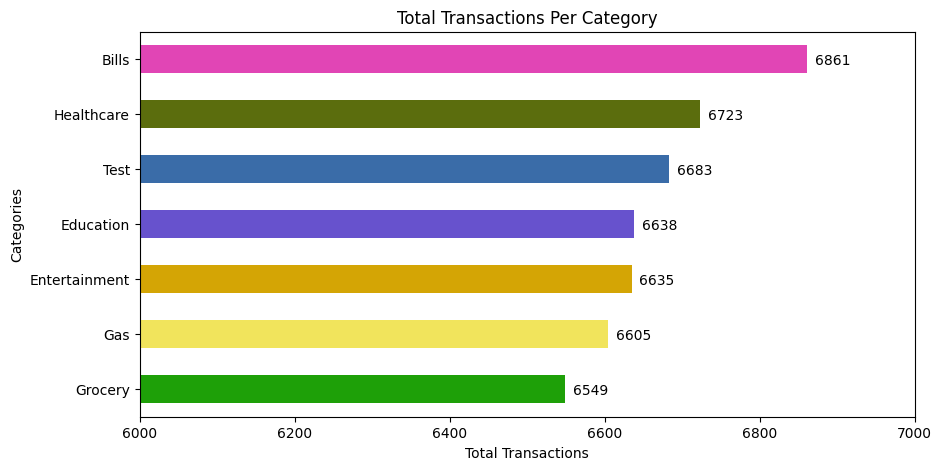

In [1023]:
plot_tran_per_category()

* 3.2. Find and plot which state has a high number of customers.

In [1024]:
#Function to plot and find state which has high number of cutomer
def plot_total_cust_per_state():
    states=cust_df['CUST_STATE'].value_counts()
    states=states.sort_values()
    st_colors=colors(len(states))
    states.plot(kind ='barh', figsize=(10,5),xlim=(0,100),color=st_colors)
    plt.title("Total Number of Customers Per State")
    for index,value in enumerate(states):
        plt.text(value+.5,index-0.1,str(value))
    plt.xlabel("Customers")
    plt.ylabel("States")
    xtick=[(i+5) for i in range(101)]
    plt.xticks([i for i in range(0,states.max()+5,5)])
    plt.annotate('State With \nHighest Number\nOf Customers', 
                    xy=(96,25),            
                    xytext=(80,22),  
                    arrowprops=dict(facecolor='black',width=1,headwidth=5),
                    horizontalalignment='left', 
                    verticalalignment='top')
    plt.show()

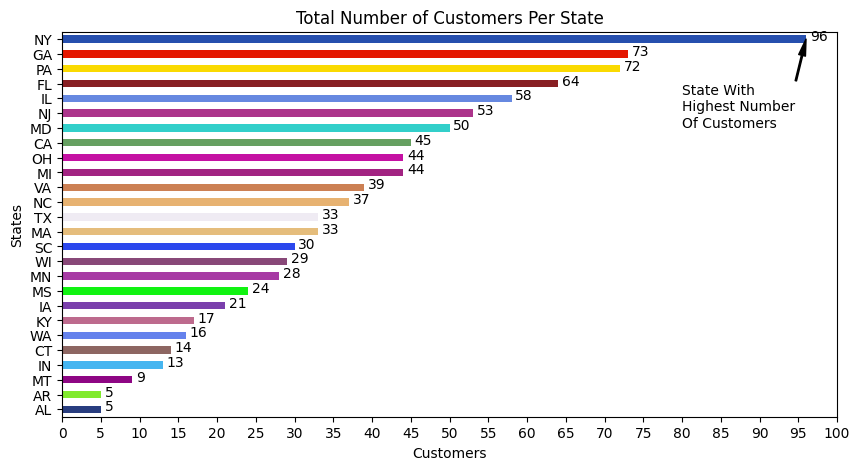

In [1025]:
#function call to plot and find state which has high number of cutomer
plot_total_cust_per_state()

* 3.3 Find and plot the sum of all transactions for each customer, and which customer has   
     the highest transaction amount.
     hint(use CUST_SSN).

In [1154]:
def plot_top_10_cust():
    #inner join on custmer dataframe and credit card dataframe
    cust_cc_df=pd.merge(cust_df,cc_df,how='inner',left_on='CREDIT_CARD_NO',right_on='CUST_CC_NO')
    top_10=cust_cc_df.groupby('CUST_SSN')['TRANSACTION_VALUE'] \
                    .sum() \
                    .sort_values().tail(10)
    top_10_colors=colors(len(top_10))
    top_10.plot(kind ='barh',figsize=(10,5),xlim=(4800,5800),color=top_10_colors)
    plt.title("Top 10 Total Transaction Amount Per Customer")
    for index,value in enumerate(top_10):
        plt.text(value+.20,index-0.2,'$'+str(value))
    plt.xlabel("Total Transaction value ")
    plt.ylabel("Customer NO")
    plt.annotate('Customer With \nHighest Transaction \n Amount', 
                xy=(5700,8.5),            
                xytext=(5600,6),  
                arrowprops=dict(facecolor='black',width=1,headwidth=5),
                horizontalalignment='left', 
                verticalalignment='center')
    plt.show()              
                

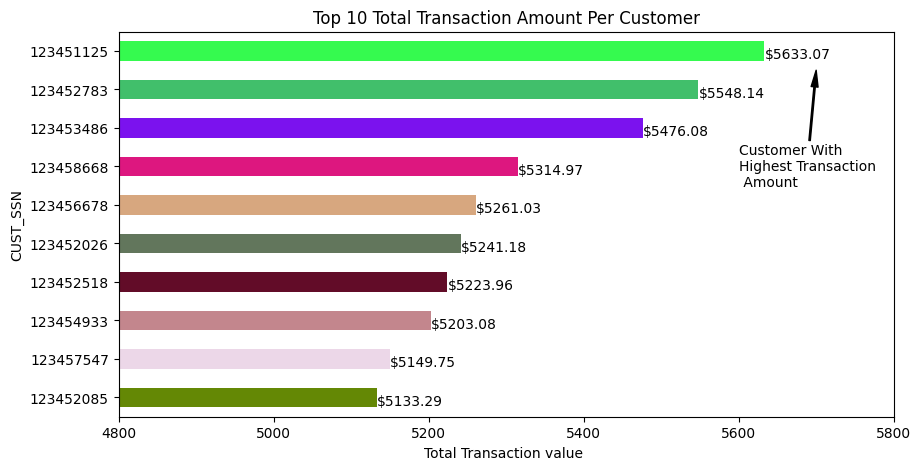

In [1155]:
plot_top_10_cust()

## LOAN application

### Req 4

* API Endpoint:

     https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json

4. Functional Requirements - LOAN Application Dataset

* 4.1 Create a Python program to GET (consume) data from the above API endpoint for the loan   
      application dataset.
* 4.2 Find the status code of the above API endpoint.
* 4.3 Once Python reads data from the API, utilize PySpark to load data into RDBMS(SQL). The table   
      name should be CDW-SAPP_loan_application in the database.



      Note: Use the “creditcard_capstone” database.




* 4.1 Create a Python program to GET (consume) data from the above API endpoint for the loan   
      application dataset.
* 4.2 Find the status code of the above API endpoint.

In [1033]:
#function to extract loan data from API end point, and display status code
def extract_loan_data():
    url="https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
    response=requests.get(url)
    loan_data=response.json()
    print("Data Extracted from API End Point")
    print("API endpoint status code :-->{}".format(response.status_code))
    return loan_data  

In [1070]:
#funcion call to extract loan data from API endpoint
loan_data=extract_loan_data()

Data Extracted from API End Point
API endpoint status code :-->200


* 4.3 Once Python reads data from the API, utilize PySpark to load data into RDBMS(SQL). The table   
      name should be                __CDW-SAPP_loan_application__ in the database.

In [1101]:
#function to load data into RDBMS
def load_data(loan_data,tablename,USER,PASSWORD):
    #create sparkSession
    # spark = SparkSession.builder.master("local[*]").appName("Capstone").getOrCreate()
    print("SparkSession Created")   
    if tables_exist("creditcard_capstone",tablename):
        print("Data has Already Loaded in RDBMS")
    else:
        loan_data_df=spark.createDataFrame(loan_data)
        loan_data_df.write \
                    .format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate","true") \
                    .option("url", "jdbc:mysql://localhost:3308/") \
                    .option("dbtable", "creditcard_capstone.{}".format(tablename)) \
                    .option("truncate","true") \
                    .option("user", USER) \
                    .option("password", PASSWORD) \
                    .option("characterEncoding","UTF-8") \
                    .option("useUnicode", "true") \
                    .save()
        print("Data Successfully loaded to {} table in RDBMS".format(tablename))
    # spark.stop()
    

In [1092]:
#function call to load lon_data to cdw_sapp_loan_application table in RDBMS
load_data(loan_data,"cdw_sapp_loan_application",USER,PASSWORD)

SparkSession Created
Data Successfully loaded to CDW_SAPP_loan_application table in RDBMS


In [1109]:
#function call to load lon_data to cdw_sapp_loan_application table in RDBMS
load_data(loan_data,"cdw_sapp_loan_application",USER,PASSWORD)

SparkSession Created
Data has Already Loaded in RDBMS


### 5 - Functional Requirements - Data Analysis and Visualization for Loan Application

### Req-5

Functional Requirements
* 5.1 Find and plot the percentage of applications approved for self-employed applicants.

* 5.2 Find the percentage of rejection for married male applicants.

* 5.3 Find and plot the top three months with the largest transaction data.

* 5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions.

 5.1 Find and plot the percentage of applications approved for self-employed applicants.

In [1164]:
def get_data(USER,PASSWORD,tablename):
    res_df=spark.read\
                .format("jdbc")\
                .options(driver="com.mysql.cj.jdbc.Driver",\
                         user=USER,\
                         password=PASSWORD,\
                         url="jdbc:mysql://localhost:3308/",\
                         dbtable="creditcard_capstone.{}".format(tablename)) \
                        .load()
    return res_df

In [1166]:
loan_df=get_data(USER,PASSWORD,"cdw_sapp_loan_application").toPandas()

In [1255]:
# def plot_self_emp(loan_df):
#     app_data=loan_df[['Application_Status','Self_Employed']]
#     emp_approval=app_data[app_data['Application_Status']=='Y'][['Self_Employed']].value_counts()
#     emp_approval.plot(kind='pie',autopct='%1.0f%%',title="Applications Approved for Self-Employed",figsize=(20,5))
#     plt.show()

In [1405]:
def plot_self_emp(loan_df):
    app_data=loan_df[['Application_Status','Self_Employed']]
    emp_approval=app_data[app_data['Application_Status']=='Y'][['Self_Employed']].value_counts()
    values=emp_approval.values.tolist()
    status=[i[0] for i in emp_approval.index.values]
    fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(aspect="equal"))
    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.2f}%\n({absolute:d})"
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: func(pct, values),
                                    textprops=dict(color="w"))
    ax.legend(wedges, status, \
            title="Self-Employed", \
            loc="upper right", \
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Approved Loan Applications")

    plt.show()

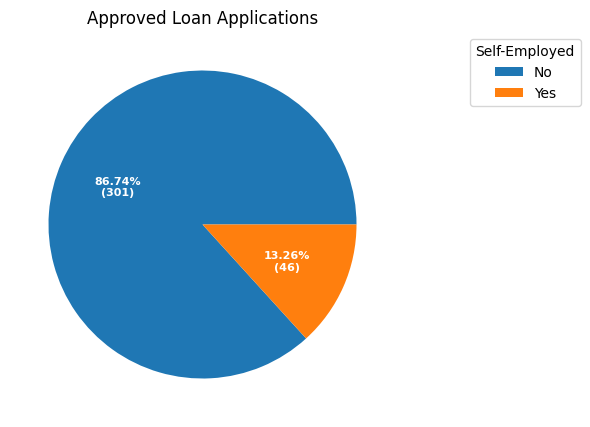

In [1406]:
plot_self_emp(loan_df)

* 5.2 Find the percentage of rejection for married male applicants.
    Note: Take a screenshot of the graph.


In [1386]:
# def plot_m_m(loan_df):
#     df_mm=loan_df[(loan_df['Married'] == 'Yes') & (loan_df['Gender']=='Male')]
#     app_df_mm=df_mm['Application_Status'].value_counts()
#     app_df_mm.plot(kind='pie',autopct='%1.0f%%',title="Percentage Applications Status for Married Men",figsize=(20,5))
#     plt.show()


In [1403]:

def plot_m_m(loan_df):
    df_mm=loan_df[(loan_df['Married'] == 'Yes') & (loan_df['Gender']=='Male')]
    app_df_mm=df_mm['Application_Status'].value_counts()
    values=app_df_mm.values.tolist()
    status=['Approved','Rejected']
    fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(aspect="equal"))
    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.2f}%\n({absolute:d})"
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: func(pct, values),
                                    textprops=dict(color="w"))
    ax.legend(wedges, status, \
            title="Application Status", \
            loc="upper right", \
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Loan Application Status for Married Men")

    plt.show()

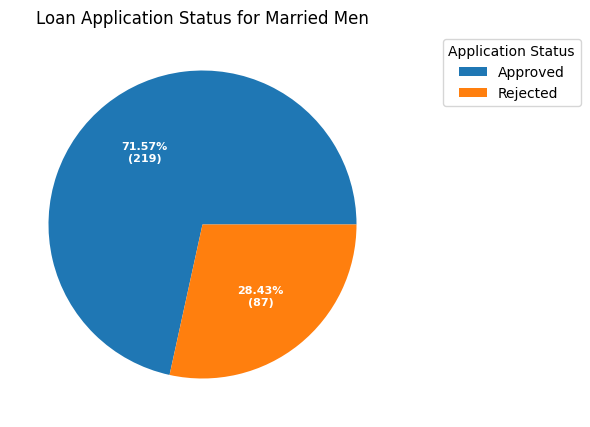

In [1404]:
plot_m_m(loan_df)

* 5.3    Find and plot the top three months with the largest transaction data.  

In [1401]:
#function to plot top 3 months of transaction
def plot_top_3_mon(cc_df):
    dates_df=cc_df.loc[:,['TIMEID','TRANSACTION_ID']]
    dates_df['TIMEID']=pd.to_datetime(dates_df['TIMEID'],format='%Y%m%d').dt.month
    top_3=dates_df['TIMEID'].value_counts().sort_values().tail(3)
    top_3.plot(kind='barh',figsize=(10,5),xlim=(3900,3970),title='Top 3 Months of Transaction')
    for index,value in enumerate(top_3):
        plt.text(value+.20,index-0.1,str(value))
    plt.ylabel("Months")
    plt.show()

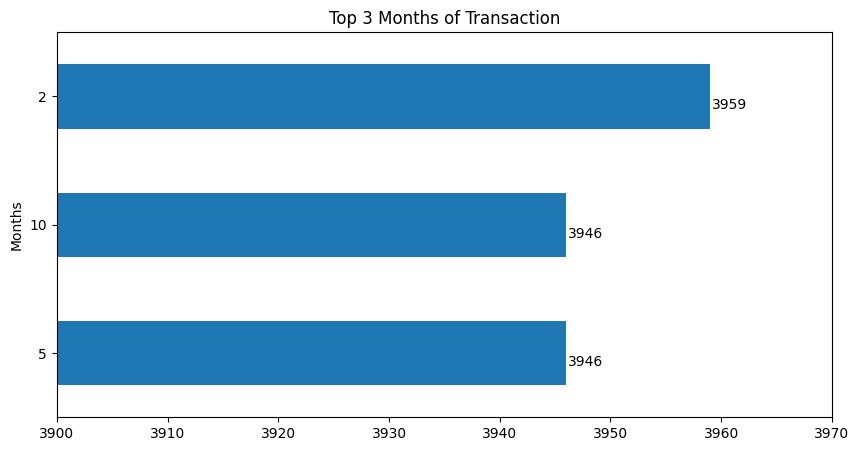

In [1402]:
plot_top_3_mon(cc_df)

* 5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions.

In [1438]:
def plot_healthcare(cc_df):
    health_branch=cc_df[cc_df['TRANSACTION_TYPE']=='Healthcare'] \
             .groupby('BRANCH_CODE',as_index=False)['TRANSACTION_VALUE'] \
             .sum()\
             .sort_values(by='TRANSACTION_VALUE',ascending=False)
    br_col=colors(len(health_branch))
    health_branch.plot(kind='scatter',x='BRANCH_CODE',y='TRANSACTION_VALUE',figsize=(40,40)\
                   ,color=br_col,xlim=(0,200))
    plt.xlabel("Branch NO")
    plt.title("Total $value of Healthcare Transactions per Branch")
    br_hl_series=health_branch.set_index('BRANCH_CODE').squeeze()
    for index,value in br_hl_series.items():
        if value==br_hl_series.max(axis=0):
            plt.text(index-5,value-120,'Highest Total',bbox=dict(facecolor='yellow',alpha=0.5))
        plt.text(index+1,value-20,'#'+str(index))


     BRANCH_CODE  TRANSACTION_VALUE
22            25            4370.18
53            60            4072.04
69            83            4003.37
31            36            3823.87
83           111            3720.27
..           ...                ...
103          160            1983.04
61            74            1965.88
113          192            1960.35
12            15            1873.71
43            49            1677.07

[114 rows x 2 columns]


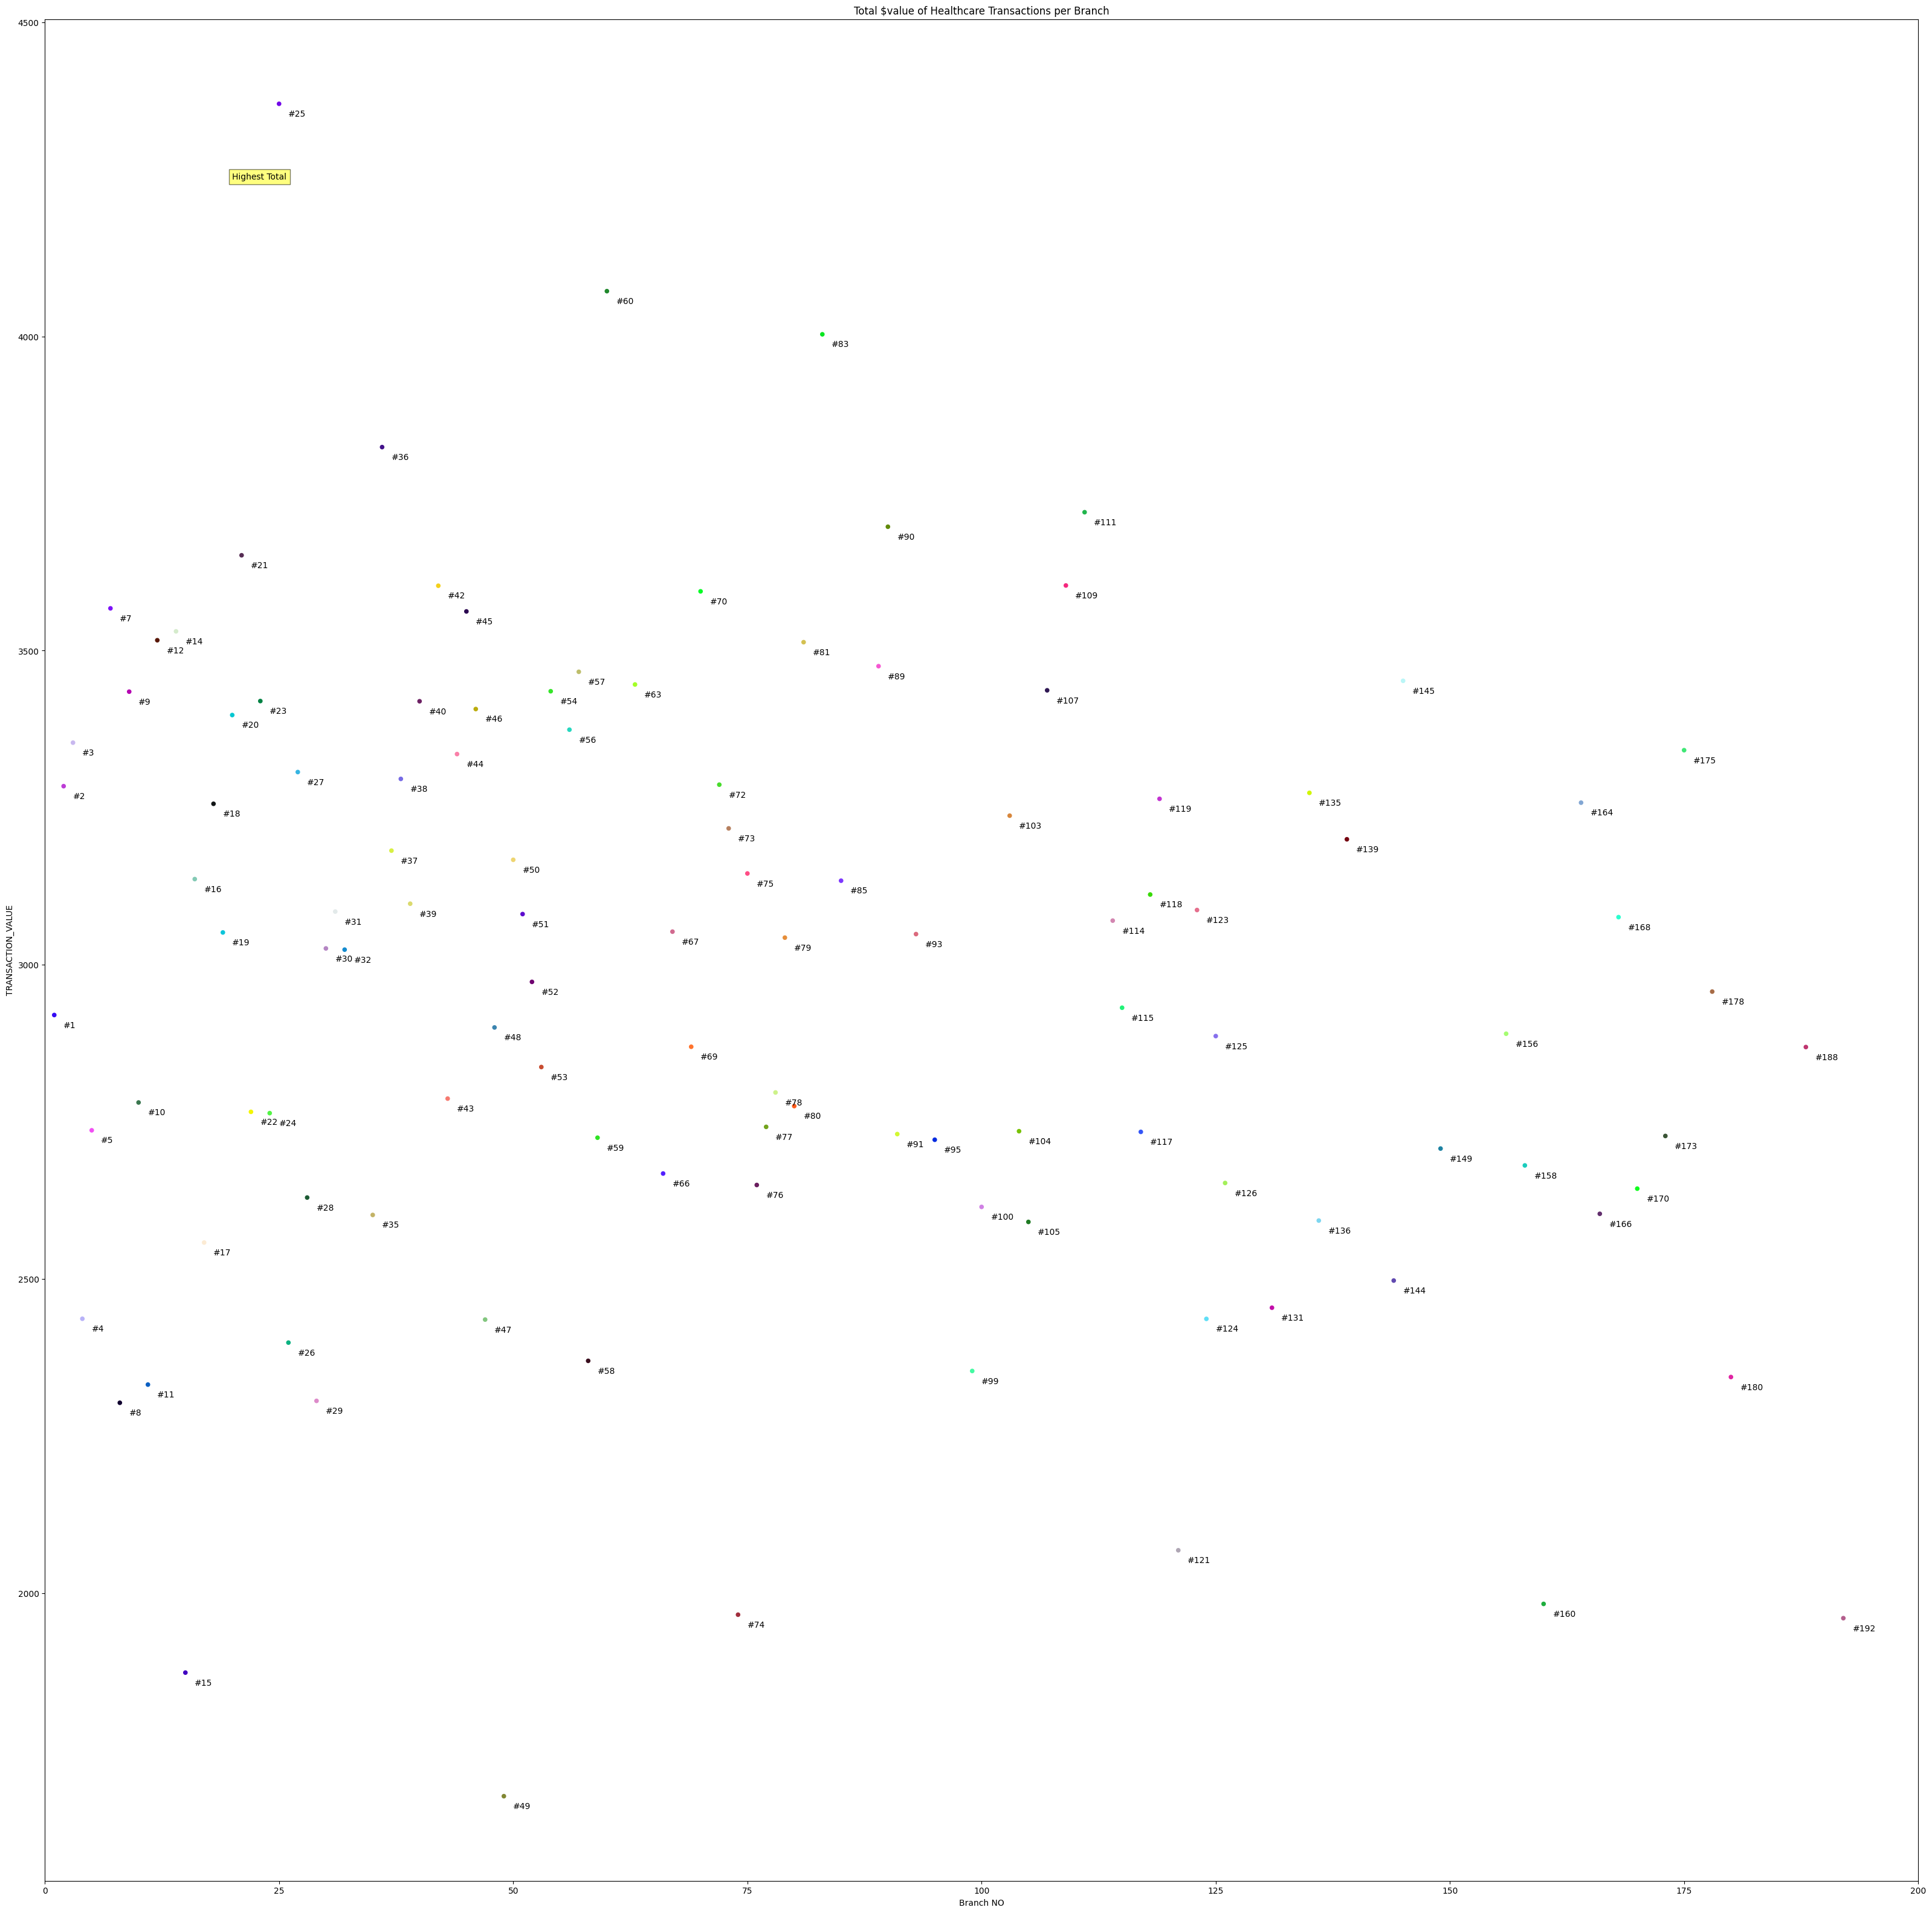

In [1439]:
plot_healthcare(cc_df)